# Lab 1:Neural Network 
This notebook has been prepared by Hsiu-Wen (Kelly) Chang from MINES ParisTech for the class machine learning

## Pytorch 

Pytorch is the most powerful open source deep learning framework. It is a replacement for NumPy (a python library for scientific computing) to use the power of GPUs and other accelerators. Also, the automatic differentiation library is useful to implement neural netorks

## Goal
Part 1: Use Numpy to build a simple neural network fit a third order polynomial to sine function.

Part 2: Practice the use of neural network from sratch: architecture, activations, training

Part 3: Practice the use of pytorch module ()


### Part 1: Numpy and Pytorch

99 1063.5981224675616
199 752.6039292946701
299 533.4254014471283
399 378.91074534732496
499 269.9565764714575
599 193.11177597119553
699 138.90221815171972
799 100.65299956491619
899 73.66010432368044
999 54.60761505287118
1099 41.157538394748805
1199 31.661023581898746
1299 24.95498387107367
1399 20.218822087076752
1499 16.873469835105766
1599 14.510225175686578
1699 12.840581438036775
1799 11.660847108170765
1899 10.82719076535085
1999 10.238035629981631
Result: y = 0.039591093917062156 + 0.8521962155337998 x + -0.0068301224993396565 x^2 + -0.09268395534800082 x^3


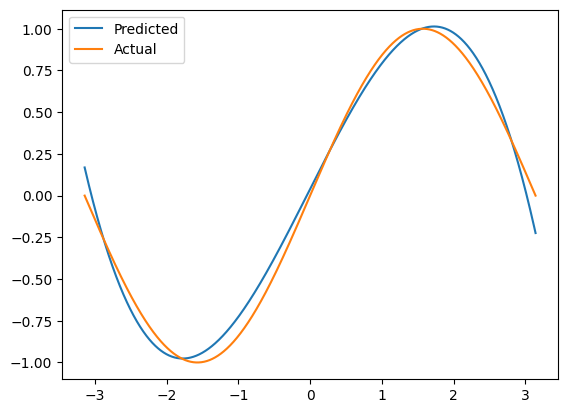

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Create random input and output data
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# Randomly initialize weights
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

# Hyperparameters
learning_rate = 1e-6
epochs = 2000
for t in range(epochs):
    # Forward pass: compute predicted y
    # y = a + b x + c x^2 + d x^3``
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

# Print final result
y_pred = a + b * x + c * x ** 2 + d * x ** 3
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')
plt.plot(x, y_pred, label='Predicted')
plt.plot(x, y, label='Actual')
plt.legend()
plt.show()

As we can see from this easy code, we need to compute gradients and manually update weights, and we are not using a GPU to accelerate the calculation. We are now starting to use PyTorch and a GPU. Before we start, you need to learn the concept of a $\textbf{tensor}$: a tensor is an n-dimensional array that can keep track of a computational graph and gradients, which is important for deep learning.

In [ ]:
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# move input and output to the device
x = torch.tensor(x, device=device, dtype=dtype)
y = torch.tensor(y, device=device, dtype=dtype)
# Randomly initialize weights (leaf tensors that require gradients)
a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute loss as a tensor (do NOT call .item() before backward)
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Backprop to compute gradients of a, b, c, d with respect to loss
    loss.backward()

    # Update weights using gradient descent WITHOUT tracking history
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Zero the gradients after updating
        a.grad.zero_()
        b.grad.zero_()
        c.grad.zero_()
        d.grad.zero_()

# Final prediction and plotting
y_pred = a + b * x + c * x ** 2 + d * x ** 3
print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')
x_cpu = x.cpu().numpy()
y_cpu = y.cpu().numpy()
y_pred_cpu = y_pred.cpu().detach().numpy()
plt.plot(x_cpu, y_pred_cpu, label='Predicted')
plt.plot(x_cpu, y_cpu, label='Actual')
plt.legend()
plt.show()

Using device: cuda:0


/tmp/ipykernel_330256/866055544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x, device=device, dtype=dtype)
/tmp/ipykernel_330256/866055544.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y, device=device, dtype=dtype)


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

### Step 1: Data preparation
----------------

To practice neural network, we are going to targeting the application of predicting the hand-drawn digits (between 0 and 9) in a given black-and-white image

There are two ways to get the datasets. This lab will use first method and the next lab will introduce the second method

(1) download raw images by URL. 
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  
You can use [pathlib](https://docs.python.org/3/library/pathlib.html)
for dealing with paths (part of the Python 3 standard library), and download the dataset using
[requests](http://docs.python-requests.org/en/master/). We will only import modules when we use them, so you can see exactly what's being used at each point.

(2) Dataset from torchvision.datasets.MNIST 


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import os
print(os.getcwd())
print((PATH / FILENAME))

/mnt/c/Users/seawi/Desktop/DLcourse-master/Kelly/DL_course_MS_HPC_IA/lab2023
data/mnist/mnist.pkl.gz


PyTorch provides the elegantly designed modules and classes. 
In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

This dataset is in numpy array format, and has been stored using pickle,
a python-specific format for serializing data.



In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



(50000, 784)


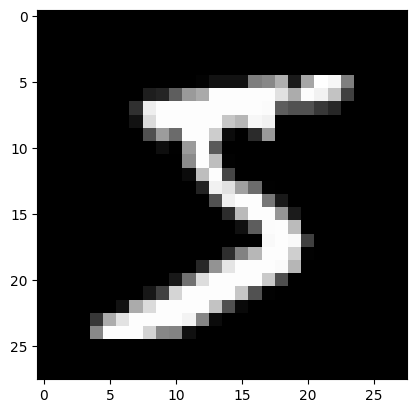

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

Neural network from scratch 
---------------------------------------------

Overall, the flowchat of the algorithm is
1. initialization
2. forward
3. loss
4. Backward
5. optimize

Let's first create a model with only one layer using nothing but PyTorch tensor operations. 
Follow these steps to create the corresponding functions

Then we will combine all of them as a class for training

(1) Use tensors to store information: x = torch.tensor(x) or any built-in functions of torch 

(2) Initialize weights by [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialisation

(3) use ``requires_grad`` to tell the computer that they require a gradient. This means that Pytorch will record all of the operations done on the tensor and calculate the gradient during back-propagation automatically.

In [ ]:
import math
# Create a NN with linear model and (28*28) inputs and 10 outputs
# TODO weights = 
# TODO bias =

Pytorch has several built-in activation functions, however, it is necessary to know how to define one by yourself. PyTorch will
even create fast GPU or vectorized CPU code for your function automatically. Let's define log_softmax function and use it as our activation to increase the complexity of our NN

$${\bf \theta} = \log\left(\frac{{\exp}({x_{i})}}{\sum_{j}{\bf \exp}({x_{j})}}\right)$$
$${\bf \theta} = x-\log{\sum_{j}{\bf \exp}({x_{j})}}$$

In [ ]:
def log_softmax(x):
    return 

def model(xb):
    return 

In the above, the ``@`` stands for the dot product operation.

Now we design a batch size of 64 to train each time

In [ ]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
print(xb.shape)
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):



In [ ]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [ ]:
yb = y_train[0:bs]
print(preds[range(yb.shape[0]),yb])
print(loss_func(preds, yb))

Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.



In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



In [ ]:
print(accuracy(preds, yb))

We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
`here <https://pytorch.org/docs/stable/notes/autograd.html>`_.

We then set the
gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).

.. tip:: You can use the standard python debugger to step through PyTorch
   code, allowing you to check the various variable values at each step.
   Uncomment ``set_trace()`` below to try it out.




In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1): #floor division
        start_i=i*bs
        end_i =start_i + bs
        # TODO grab batch of data (xb) and targets (yb)
        # TODO predict output
        # TODO calculate loss
        # TODO backpropagation error
        with torch.no_grad():
            #TODO update weights and bias

            weights.grad.zero_()
            bias.grad.zeros_()

    print('Epochs {}: loss {}, accuracy {}'.format(epoch, loss_func(model(xb), yb), accuracy(model(xb), yb)))

That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

Assignment 1: Using torch.nn.functional
------------------------------
The above work can be easily done by using torch.nn.functional. Please rewrite the above code to be more concise and flexible. Make it shorter, more understandable.

Here is the list of modules that you should try to read:
1. [torch.nn](https://pytorch.org/docs/stable/nn.html)
2. [torch.optim](https://pytorch.org/docs/stable/optim.html)
3. [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)
4. [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

### Step 1 
find activation and loss function from ``torch.nn.functional``

In [ ]:
# Check your loss and accuracy are the same like before
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

### Step 2
Use a class to define the architecture

In [ ]:
from torch import nn

Instantiate your model and check your loss value



In [ ]:
model = Mnist_Logistic()

In [ ]:
print(loss_func(model(xb), yb))

### Step 3 improve training loop
rewrite the way to update of weights and bias by using nn.Module.parameters and nn.Module.zero_grad()

define a function call fit() to wrap your training loop


In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):

Instantiate your function and check loss value



In [ ]:
fit()
print(loss_func(model(xb), yb))

### Step 4: use nn.Linear
redefine your nn class and replace layer by using [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) 

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, xb):
        

Instantiate our model and calculate the loss in the same way as before:

In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

We are still able to use our same ``fit`` method as before.



In [ ]:
fit()

print(loss_func(model(xb), yb))

### Step 5 using optim

``torch.optim`` provides various optimization algorithms.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

replace our previous manually coded optimization step:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

In [ ]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [ ]:
def get_model():
    model = Mnist_Logistic()
    return # TODO stochastic gradient descent

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # TODO

print(loss_func(model(xb), yb))

### Step 6 using TensorDataset

PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python's standard len function) and a __getitem__ function as a way of indexing into it. This [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch's [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset) is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [ ]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

### Step 6 using DataLoader

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.



In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=bs)

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    # TODO

print(loss_func(model(xb), yb))

Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effecive models in practice.

## Advance functions to make it more effective 

### Step 7 Add validation
In reality, we always need to take care the overfitting issue. We can avoid it by:
(1) add validation
(2) shuffling the training data prevent correlation between batches and overfitting. 

In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    # TODO

    print(epoch, valid_loss / len(valid_dl))

## Final three lines code

Create fit() and get_data()

(1) Define a function ``loss_batch`` which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

(2) ``fit`` runs the necessary operations to train our model and compute the training and validation losses for each epoch.



In [ ]:
import numpy as np
# meaning of * is to unpacks a list or tuple into position arguments

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() #set the mode to training mode. if we use model.train(false), it will become evaluation mode
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

(3) ``get_data`` returns dataloaders for the training and validation sets.



In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [ ]:
# TODO

# Assignment 2: plot loss values and validations values
In order to understand the progress of your training, error curves with test and validation are very common to be shown.
Change your code in order to see the curves

You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Summary 
-----------------

We have seen and practice the following functions

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

